In [6]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import pandas as pd
from torchvision.io import read_image

In [7]:
def encode_label(label):
    labels = ['Snail', 'Water', 'Plant', 'Cattle', 'Grain', 'Bird', 'People', 'Animal', 'Snake']
    for i in range(len(labels)):
        if label == labels[i]:
            return i
    
    return -1

def decode_label(code):
    labels = ['Snail', 'Water', 'Plant', 'Cattle', 'Grain', 'Bird', 'People', 'Animal', 'Snake']
    return labels[code]
    

In [11]:
# Self-defined dataset class
class HieroglyphicsDataset(Dataset):
    def __init__(self, directory_path, mode, transform=None, target_transform=None):
        assert(mode == 'train' or mode == 'test')
        
        self.data = []
        self.transform = transform
        self.target_transform = target_transform
        
        print('You are creating a %s dataset from %s.' % (mode, directory_path))
              
        for _, categories, _ in os.walk(directory_path):
            for category in categories:
                if (category.split('.')[-1] in ['DS_Store', 'ipynb_checkpoints']):
                    continue
                    
                label = encode_label(category)
                label = torch.tensor(label)
                if self.target_transform:
                    label = self.target_transform(label)
                    
                category_path = os.path.join(directory_path, category)
                for _, _, image_files in os.walk(category_path):
              
                    # Split dataset into training and testing subsets
                    divider = (int)(len(image_files)*1)
                    if mode == 'train':
                        image_files = image_files[:divider]
                    elif mode == 'test':
                        image_files = image_files[divider:]
                    
                    # Add image 
                    count = 0
                    for image_file in image_files:
                        if not (image_file.split('.')[-1] in ['jpg', 'jpeg', 'png']):
                            continue
                        
                        image_path = os.path.join(category_path, image_file)
                        image = read_image(image_path)/255
                        if self.transform:
                            image = self.transform(image)
                        self.data.append((image, label))
                        count += 1

                    # Summarize
                    print('\t%s - %d' % (category, count))
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    

class DemoDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.data = []
        self.transform = transform
        
        image = read_image(image_path)/255
        if self.transform:
            image = self.transform(image)
            
        self.data.append((image, torch.tensor(-1)))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
trainset = HieroglyphicsDataset('./data/categorized_images', 'train', transform=transforms.Compose([
    transforms.Resize((224, 224))]),
)
testset = HieroglyphicsDataset('./data/categorized_images', 'train', transform=transforms.Compose([
    transforms.Resize((224, 224))]),)

You are creating a train dataset from ./data/categorized_images.
	Snail - 10
	Water - 44
	Plant - 22
	Cattle - 10
	Grain - 24
	Bird - 81
	People - 29
	Animal - 10
	Snake - 5
You are creating a train dataset from ./data/categorized_images.
	Snail - 10
	Water - 44
	Plant - 22


# Load data

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(trainset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=4, shuffle=True)

ValueError: num_samples should be a positive integer value, but got num_samples=0

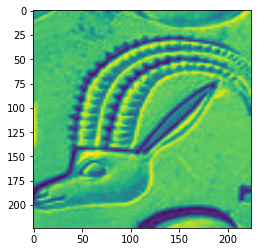

Label: Cattle
tensor([[0.4353, 0.4390, 0.4610,  ..., 0.9252, 0.8885, 0.8824],
        [0.4502, 0.4545, 0.4801,  ..., 0.9073, 0.8725, 0.8667],
        [0.4862, 0.4920, 0.5265,  ..., 0.8640, 0.8339, 0.8289],
        ...,
        [0.7139, 0.7141, 0.7150,  ..., 0.6605, 0.6826, 0.6863],
        [0.7193, 0.7194, 0.7197,  ..., 0.6739, 0.6845, 0.6863],
        [0.7216, 0.7216, 0.7216,  ..., 0.6794, 0.6853, 0.6863]])


In [18]:
# Check
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0][1] # We only visualize one channel since all the channels are the same
label = train_labels[0]

plt.imshow(img)
plt.show()
print(f"Label: {decode_label(label)}")

print(img)

# Train

In [19]:
# Related modules
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [20]:
# Hyper parameters
lr = 0.01
momentum = 0.9
epochs = 5

In [21]:
class MyNet(nn.Module):
    def __init__(self, category_num):
        super(MyNet, self).__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        self.end = nn.Linear(1000, category_num, bias=True)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.end(x)
        
        return x

In [32]:
model = MyNet(category_num=9)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [33]:
def train(model, criterion, optimizer, epoch, train_loader):
    model.train()
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

In [12]:
for epoch in range(epochs):
    train(model, criterion, optimizer, epoch, train_dataloader)

/Users/melialiu/opt/miniconda3/envs/cs172/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    10] loss: 5.774
[1,    20] loss: 15.949
[1,    30] loss: 20.582
[1,    40] loss: 9.463
[1,    50] loss: 8.057
[2,    10] loss: 4.041
[2,    20] loss: 2.653
[2,    30] loss: 2.084
[2,    40] loss: 2.097
[2,    50] loss: 2.527
[3,    10] loss: 1.766
[3,    20] loss: 2.919
[3,    30] loss: 2.345
[3,    40] loss: 1.963
[3,    50] loss: 1.878
[4,    10] loss: 1.995
[4,    20] loss: 2.244
[4,    30] loss: 2.561
[4,    40] loss: 1.918
[4,    50] loss: 1.809
[5,    10] loss: 1.829
[5,    20] loss: 1.753
[5,    30] loss: 1.838
[5,    40] loss: 1.466
[5,    50] loss: 1.951


In [59]:
# Save model
PATH = './models/model_on_boardset.pth'
torch.save(model.state_dict(), PATH)

# Test

In [34]:
def test(model, test_loader):
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %d %%' % 
          (total, 100 * correct / total))

def test_category(model, test_loader):
    model.eval()
    
    classes = ['Snail', 'Water', 'Plant', 'Cattle', 'Grain', 'Bird', 'People', 'Animal', 'Snake']
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    
    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} % ({} / {})".format(
                classname,
                accuracy,
                correct_count,
                total_pred[classname])
             )

In [24]:
# Load model
PATH = './models/model_on_boardset.pth'
model = MyNet(category_num=9)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [37]:
test(model, train_dataloader)

NameError: name 'test' is not defined

In [38]:
test_category(model, train_dataloader)

NameError: name 'test_category' is not defined

# HOG

In [37]:
import cv2
import numpy as np
hog = cv2.HOGDescriptor()

In [40]:
img1 = cv2.imread('./char_new_dataset/Bird/all_characters_without_space_page-0286.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./board_dataset/Animal/animal_1.jpg', cv2.IMREAD_GRAYSCALE)

img1 = cv2.resize(img1, (200, 200), interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2, (200, 200), interpolation = cv2.INTER_AREA)



In [41]:
print(type(img1), img1.shape)
print(type(img2), img2.shape)

des1 = hog.compute(img1)
des2 = hog.compute(img2)

<class 'numpy.ndarray'> (200, 200)
<class 'numpy.ndarray'> (200, 200)


In [54]:
img_tensor = read_image('./demotest_dataset/test/plant_7.jpg')
img_numpy = cv2.imread('./demotest_dataset/test/plant_7.jpg', cv2.IMREAD_GRAYSCALE)

In [55]:
print(type(img_tensor))
print(type(img_numpy))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


In [48]:
testset = HieroglyphicsDataset('./demotest_dataset', 'train', transform=transforms.Compose([
    transforms.Resize((224, 224))]))
test_dataloader = DataLoader(testset, batch_size=1, shuffle=False)

You are creating a train dataset from ./demotest_dataset.
plant_7.jpg
	test - 1


In [49]:
for data in test_dataloader:
    images, labels = data
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    print(decode_label(predictions[0]))

Plant


In [27]:
demo_set =  DemoDataset('./demotest_dataset/plant_7.jpg', transform=transforms.Compose([
    transforms.Resize((224, 224))]))

In [28]:
test_dataloader = DataLoader(demo_set, batch_size=1, shuffle=False)

print(test_dataloader)

In [29]:
for data in test_dataloader:
    images, labels = data
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    print(decode_label(predictions[0]))

/Users/melialiu/opt/miniconda3/envs/cs172/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Plant


In [6]:
def predict_class(model, image_path):
    dataset =  DemoDataset(image_path, transform=transforms.Compose([
        transforms.Resize((224, 224))]))
    test_dataloader = DataLoader(demo_set, batch_size=1, shuffle=False)
    
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
    return decode_label(predictions[0])

In [31]:
predict_class(model, './demotest_dataset/plant_7.jpg')

'Plant'

In [40]:
def predict_char(pred_class, folder_path, image_path):
    hog = cv2.HOGDescriptor()
    img = cv2.resize(cv2.imread(image_path), (200, 200), interpolation = cv2.INTER_AREA)
    des = hog.compute(img)
    
    character_files = []
    character_diffs = []
    for _, categories, _ in os.walk(folder_path):
        for category in categories:
            if (category == pred_class):
                category_path = os.path.join(folder_path, category)
                for _, _, char_files in os.walk(category_path):
                    for char_file in char_files:
                        print(char_file.split('.')[-1])
                        if not (char_file.split('.')[-1] in ['jpg', 'jpeg', 'png']):
                            continue

                        temp_file_path = os.path.join(category_path, char_file)
                        character_files.append(temp_file_path)

                        temp_img = cv2.resize(cv2.imread(image_path), (200, 200), interpolation = cv2.INTER_AREA)
                        temp_des = hog.compute(temp_img)
                        diff = np.sqrt(np.abs((des-temp_des))).sum()
                        character_diffs.append(diff)
                
        idx = character_diffs.index(min(character_diffs))
        char_file_path = character_files[idx]

        img = mpimg.imread(char_file_path)
        imgplot = plt.imshow(img)

jpg
jpg
jpg
jpg
jpg
jpg
jpg


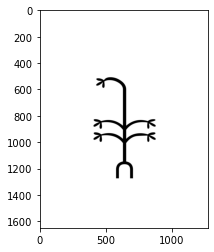

In [41]:
image_path = './demotest_dataset/plant_7.jpg'
folder_path = './char_new_dataset'

pred_class = predict_class(model, image_path)
predict_char(pred_class, folder_path, image_path)

In [5]:
from segmentation import select_char
from classify import Classifier
from torch.utils.data import DataLoader, Dataset
from net import MyNet

import torch

class DemoDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.data = []
        self.transform = transform
        
        image = read_image(image_path)/255
        if self.transform:
            image = self.transform(image)
            
        self.data.append((image, torch.tensor(-1)))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def predict_class(model, image_path):
    testset = DemoDataset(image_path, transform=transforms.Compose([
                        transforms.Resize((224, 224))]))
    test_dataloader = DataLoader(testset, batch_size=1, shuffle=False)

    for data in test_dataloader:
        images, labels = data

        outputs = model(images)

        _, predictions = torch.max(outputs, 1)

        pred_category = label = decode_label(predictions[0])
        print('Predicted category:', pred_category)
 
        return pred_category

test_img_path = './test.jpg'

model_path = './models/model_on_boardset.pth'
model = MyNet(category_num=9)
model.load_state_dict(torch.load(model_path))

char_folder_path = './data/categorized_characters'
classifier = Classifier(model)
pred_category = predict_class(model, test_img_path)
classifier.predict_char(pred_category, char_folder_path, test_img_path)


NameError: name 'transforms' is not defined